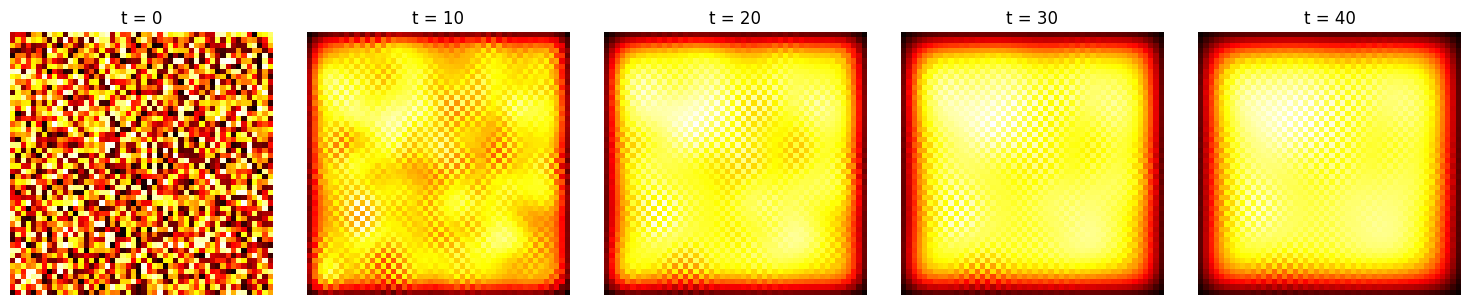

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

def initialize_grid(size):
    grid = np.random.rand(size, size)
    return grid

def apply_diffusion(grid, diffusion_rate=0.1):
    kernel = diffusion_rate * np.array([[0, 1, 0],
                                        [1, -4, 1],
                                        [0, 1, 0]])
    return grid + convolve(grid, kernel, mode='constant', cval=0.0)

def plot_grid(grid, time_step, ax):
    ax.imshow(grid, cmap='hot', interpolation='nearest')
    ax.set_title(f"t = {time_step}")
    ax.axis('off')

def main():
    # 初始化参数
    grid_size = 50
    num_steps = 50
    diffusion_rate = 0.25

    grid = initialize_grid(grid_size)

    fig, axs = plt.subplots(1, num_steps//10, figsize=(15, 3))
    
    for step in range(num_steps):
        if step % 10 == 0:
            plot_grid(grid, step, axs[step//10])    
        grid = apply_diffusion(grid, diffusion_rate)
    
    plt.tight_layout()
    plt.show()

main()

In [2]:
# get the current path "GREAD/notebook" and the abs path of "GREAD/src" directory
import os
current_path = os.getcwd()   # get the current path
print(current_path)  
module_path = os.path.abspath(os.path.join('../src'))   # relative path: ../src, turn it to absollute path
print(module_path)  

# add the module_path to sys.path
import sys
if module_path not in sys.path:
    sys.path.append(module_path)
print(sys.path)

/root/autodl-tmp/GREAD/src
/root/autodl-tmp/GREAD/src
['/root/miniconda3/envs/grade/lib/python310.zip', '/root/miniconda3/envs/grade/lib/python3.10', '/root/miniconda3/envs/grade/lib/python3.10/lib-dynload', '', '/root/miniconda3/envs/grade/lib/python3.10/site-packages', '/root/autodl-tmp/GREAD/src']


In [3]:
import torch
from torch_geometric.data import Data, InMemoryDataset

In [4]:
# opt
opt = {'self_loop_weight': 1, 'leaky_relu_slope': 0.2, 'beta_dim': 'vc', 'heads': 2,
                'K': 10,
                'attention_norm_idx': 0, 'add_source': False, 'alpha': 1, 'alpha_dim': 'vc', 'beta_dim': 'vc',
                'hidden_dim': 6, 'augment': False, 'adjoint': False,
                'tol_scale': 1, 'time': 1, 'ode': 'ode', 'input_dropout': 0.5, 'dropout': 0.5, 'method': 'euler',
                'block': 'constant', 'function': 'gread', 'reaction_term': "aggdiff-gauss", 'rewiring': None, 'no_alpha_sigmoid': False,
                'reweight_attention': False, 'kinetic_energy': None, 'jacobian_norm2': None, 'total_deriv': None, 'directional_penalty': None
                , 'step_size': 1, 'data_norm': 'rw', 'max_iters': 10, 'beltrami': False, "use_mlp": True, "use_labels": False, "fc_out": False,
                "m2_mlp":False, "batch_norm":False, "source_dim": "vc", "trusted_mask":False, 'beta_diag':True, "max_nfe": 1000, 'XN_activation':False}

In [5]:
# generate random data
# 生成节点特征
num_nodes = 50
num_features = 20
x = torch.rand(num_nodes, num_features)
# 生成边连接
num_edges = 500
# 每条边包含源节点索引和目标节点索引
edge_index = torch.randint(0, num_nodes, (2, num_edges), dtype=torch.long)
# 生成节点标签
num_classes = 7
y = torch.randint(0, num_classes, (num_nodes,))
data = Data(x=x, edge_index=edge_index, y=y,num_classes=num_classes, num_features=num_features, num_nodes=num_nodes, num_edges=num_edges)

In [6]:
import torch
from torch import nn
from torch_geometric.nn.conv import MessagePassing
from utils import Meter
from regularized_ODE_function import RegularizedODEfunc
import regularized_ODE_function as reg_lib
import six
import torch.nn.functional as F


REGULARIZATION_FNS = {
    "kinetic_energy": reg_lib.quadratic_cost,
    "jacobian_norm2": reg_lib.jacobian_frobenius_regularization_fn,
    "total_deriv": reg_lib.total_derivative,
    "directional_penalty": reg_lib.directional_derivative
}


def create_regularization_fns(args):
    regularization_fns = []
    regularization_coeffs = []

    for arg_key, reg_fn in six.iteritems(REGULARIZATION_FNS):
        if args[arg_key] is not None:
            regularization_fns.append(reg_fn)
            regularization_coeffs.append(args[arg_key])

    regularization_fns = regularization_fns
    regularization_coeffs = regularization_coeffs
    return regularization_fns, regularization_coeffs


class ODEblock(nn.Module):
  def __init__(self, odefunc, regularization_fns, opt, data, device, t):
    super(ODEblock, self).__init__()
    self.opt = opt
    self.t = t
    
    self.aug_dim = 2 if opt['augment'] else 1
    self.odefunc = odefunc(self.aug_dim * opt['hidden_dim'], self.aug_dim * opt['hidden_dim'], opt, data, device)
    
    self.nreg = len(regularization_fns)
    self.reg_odefunc = RegularizedODEfunc(self.odefunc, regularization_fns)

    if opt['adjoint']:
      from torchdiffeq import odeint_adjoint as odeint
    else:
      from torchdiffeq import odeint
    self.train_integrator = odeint
    self.test_integrator = None
    self.set_tol()

  def set_x0(self, x0):
    self.odefunc.x0 = x0.clone().detach()
    self.reg_odefunc.odefunc.x0 = x0.clone().detach()

  def set_tol(self):
    self.atol = self.opt['tol_scale'] * 1e-7
    self.rtol = self.opt['tol_scale'] * 1e-9
    if self.opt['adjoint']:
      self.atol_adjoint = self.opt['tol_scale_adjoint'] * 1e-7
      self.rtol_adjoint = self.opt['tol_scale_adjoint'] * 1e-9

  def reset_tol(self):
    self.atol = 1e-7
    self.rtol = 1e-9
    self.atol_adjoint = 1e-7
    self.rtol_adjoint = 1e-9

  def set_time(self, time):
    self.t = torch.tensor([0, time]).to(self.device)

  def __repr__(self):
    return self.__class__.__name__ + '( Time Interval ' + str(self.t[0].item()) + ' -> ' + str(self.t[1].item()) \
           + ")"


class ODEFunc(MessagePassing):

  # currently requires in_features = out_features
  def __init__(self, opt, data, device):
    super(ODEFunc, self).__init__()
    self.opt = opt
    self.device = device
    self.edge_index = None
    self.edge_weight = None
    self.attention_weights = None
    if opt['alpha_dim'] == 'sc':
      self.alpha_train = nn.Parameter(torch.tensor(0.0))
    elif opt['alpha_dim'] == 'vc':
      self.alpha_train = nn.Parameter(0.0*torch.ones(1,opt['hidden_dim']))
    if opt['source_dim'] == 'sc':
      self.source_train = nn.Parameter(torch.tensor(0.0))
    elif opt['source_dim'] == 'vc':
      self.source_train = nn.Parameter(0.0*torch.ones(1,opt['hidden_dim']))
    if opt['beta_dim'] == 'sc':
      self.beta_train = nn.Parameter(torch.tensor(0.0))
    elif opt['beta_dim'] == 'vc':
      self.beta_train = nn.Parameter(0.0*torch.ones(1,opt['hidden_dim']))
    self.x0 = None
    self.nfe = 0
    self.alpha_sc = nn.Parameter(torch.ones(1))
    self.source_sc = nn.Parameter(torch.ones(1))

  def __repr__(self):
    return self.__class__.__name__


class BaseGNN(MessagePassing):
  def __init__(self, opt, data, device=torch.device('cpu')):
    super(BaseGNN, self).__init__()
    self.opt = opt
    self.T = opt['time']
    self.num_classes = data.num_classes
    self.num_features = data.num_features
    self.num_nodes = data.num_nodes
    self.device = device
    self.fm = Meter()
    self.bm = Meter()

    if opt['beltrami']:
      # self.mx = nn.Linear(self.num_features, opt['hidden_dim'])
      self.mx = nn.Linear(self.num_features, opt['feat_hidden_dim'])
      self.mp = nn.Linear(opt['pos_enc_dim'], opt['pos_enc_hidden_dim'])
      if opt['wandb']:
        import wandb; wandb.config.update({'hidden_dim': opt['feat_hidden_dim'] + opt['pos_enc_hidden_dim']}, allow_val_change=True)
      else:
        try:
          opt['hidden_dim'] = opt['feat_hidden_dim'] + opt['pos_enc_hidden_dim']
        except:
          print("Something went wrong when update wandb configs")
        # finally:
        #   import wandb; wandb.config.update({'hidden_dim': opt['hidden_dim'] + opt['pos_enc_hidden_dim']}, allow_val_change=True)
    else:
      self.m1 = nn.Linear(self.num_features, opt['hidden_dim'])

    if self.opt['use_mlp']:
      self.m11 = nn.Linear(opt['hidden_dim'], opt['hidden_dim'])
      self.m12 = nn.Linear(opt['hidden_dim'], opt['hidden_dim'])
    if opt['use_labels']:
      # todo - fastest way to propagate this everywhere, but error prone - refactor later
      opt['hidden_dim'] = opt['hidden_dim'] + data.num_classes
    else:
      self.hidden_dim = opt['hidden_dim']
    if opt['fc_out']:
      self.fc = nn.Linear(opt['hidden_dim'], opt['hidden_dim'])

    if opt['m2_mlp']:
      self.m2 = M2_MLP(opt, data, device=device)
    else:
      self.m2 = nn.Linear(opt['hidden_dim'], data.num_classes)


    if self.opt['batch_norm']:
      self.bn_in = torch.nn.BatchNorm1d(opt['hidden_dim'])
      self.bn_out = torch.nn.BatchNorm1d(opt['hidden_dim'])

    self.regularization_fns, self.regularization_coeffs = create_regularization_fns(self.opt)

  def getNFE(self):
    return self.odeblock.odefunc.nfe + self.odeblock.reg_odefunc.odefunc.nfe

  def resetNFE(self):
    self.odeblock.odefunc.nfe = 0
    self.odeblock.reg_odefunc.odefunc.nfe = 0

  def reset(self):
    self.m1.reset_parameters()
    self.m2.reset_parameters()

  def __repr__(self):
    return self.__class__.__name__
  
  def compute_energy(self,x,edge_index):
    energy = self.propagate(edge_index, x=x,energy = True)
    return torch.mean(energy,dim=0).item()

  def message(self, x_i,x_j,energy):
    # x_j has shape [E, out_channels]
    # Step 4: Normalize node features.
    #[E,1]*[E,channel]
    if energy:
        return (torch.linalg.norm(x_j-x_i, dim=1)**2).unsqueeze(dim=1)

def compute_enegry_evolution(self, edge_index, t_list):
  inter_step = self.odeblock.integrateAt(t_list)
  energy_list = [self.compute_energy(inter_step[i], edge_index) for i in range(inter_step.shape[0])]
  return energy_list

class M2_MLP(nn.Module):
  def __init__(self, opt, data, device=torch.device('cpu')):
    super().__init__()
    self.opt = opt
    self.m21 = nn.Linear(opt['hidden_dim'], opt['hidden_dim'])
    self.m22 = nn.Linear(opt['hidden_dim'], data.num_classes)

  def forward(self, x):
    x = F.dropout(x, self.opt['dropout'], training=self.training)
    x = F.dropout(x + self.m21(torch.tanh(x)), self.opt['dropout'], training=self.training)  # tanh not relu to keep sign, with skip connection
    x = F.dropout(self.m22(torch.tanh(x)), self.opt['dropout'], training=self.training)

    return x

In [7]:
from torch import nn
from torch_geometric.nn.conv import MessagePassing
from utils import Meter
from regularized_ODE_function import RegularizedODEfunc
import regularized_ODE_function as reg_lib
import six
import torch.nn.functional as F

REGULARIZATION_FNS = {
    "kinetic_energy": reg_lib.quadratic_cost,
    "jacobian_norm2": reg_lib.jacobian_frobenius_regularization_fn,
    "total_deriv": reg_lib.total_derivative,
    "directional_penalty": reg_lib.directional_derivative
}

def create_regularization_fns(args):
    regularization_fns = []
    regularization_coeffs = []

    for arg_key, reg_fn in six.iteritems(REGULARIZATION_FNS):
        if args[arg_key] is not None:
            regularization_fns.append(reg_fn)
            regularization_coeffs.append(args[arg_key])

    regularization_fns = regularization_fns
    regularization_coeffs = regularization_coeffs
    return regularization_fns, regularization_coeffs

class ODEblock(nn.Module):
  def __init__(self, odefunc, regularization_fns, opt, data, device, t):
    super(ODEblock, self).__init__()
    self.opt = opt
    self.t = t
    
    self.aug_dim = 2 if opt['augment'] else 1
    self.odefunc = odefunc(self.aug_dim * opt['hidden_dim'], self.aug_dim * opt['hidden_dim'], opt, data, device)
    
    self.nreg = len(regularization_fns)
    self.reg_odefunc = RegularizedODEfunc(self.odefunc, regularization_fns)

    if opt['adjoint']:
      from torchdiffeq import odeint_adjoint as odeint
    else:
      from torchdiffeq import odeint
    self.train_integrator = odeint
    self.test_integrator = None
    self.set_tol()

  def set_x0(self, x0):
    self.odefunc.x0 = x0.clone().detach()
    self.reg_odefunc.odefunc.x0 = x0.clone().detach()

  def set_tol(self):
    self.atol = self.opt['tol_scale'] * 1e-7
    self.rtol = self.opt['tol_scale'] * 1e-9
    if self.opt['adjoint']:
      self.atol_adjoint = self.opt['tol_scale_adjoint'] * 1e-7
      self.rtol_adjoint = self.opt['tol_scale_adjoint'] * 1e-9

  def reset_tol(self):
    self.atol = 1e-7
    self.rtol = 1e-9
    self.atol_adjoint = 1e-7
    self.rtol_adjoint = 1e-9

  def set_time(self, time):
    self.t = torch.tensor([0, time]).to(self.device)

  def __repr__(self):
    return self.__class__.__name__ + '( Time Interval ' + str(self.t[0].item()) + ' -> ' + str(self.t[1].item()) \
           + ")"

class ODEFunc(MessagePassing):

  # currently requires in_features = out_features
  def __init__(self, opt, data, device):
    super(ODEFunc, self).__init__()
    self.opt = opt
    self.device = device
    self.edge_index = None
    self.edge_weight = None
    self.attention_weights = None
    if opt['alpha_dim'] == 'sc':
      self.alpha_train = nn.Parameter(torch.tensor(0.0))
    elif opt['alpha_dim'] == 'vc':
      self.alpha_train = nn.Parameter(0.0*torch.ones(1,opt['hidden_dim']))
    if opt['source_dim'] == 'sc':
      self.source_train = nn.Parameter(torch.tensor(0.0))
    elif opt['source_dim'] == 'vc':
      self.source_train = nn.Parameter(0.0*torch.ones(1,opt['hidden_dim']))
    if opt['beta_dim'] == 'sc':
      self.beta_train = nn.Parameter(torch.tensor(0.0))
    elif opt['beta_dim'] == 'vc':
      self.beta_train = nn.Parameter(0.0*torch.ones(1,opt['hidden_dim']))
    self.x0 = None
    self.nfe = 0
    self.alpha_sc = nn.Parameter(torch.ones(1))
    self.source_sc = nn.Parameter(torch.ones(1))

  def __repr__(self):
    return self.__class__.__name__

class BaseGNN(MessagePassing):
  def __init__(self, opt, data, device=torch.device('cpu')):
    super(BaseGNN, self).__init__()
    self.opt = opt
    self.T = opt['time']
    self.num_classes = data.num_classes
    self.num_features = data.num_features
    self.num_nodes = data.num_nodes
    self.device = device
    self.fm = Meter()
    self.bm = Meter()

    if opt['beltrami']:
      # self.mx = nn.Linear(self.num_features, opt['hidden_dim'])
      self.mx = nn.Linear(self.num_features, opt['feat_hidden_dim'])
      self.mp = nn.Linear(opt['pos_enc_dim'], opt['pos_enc_hidden_dim'])
      if opt['wandb']:
        import wandb; wandb.config.update({'hidden_dim': opt['feat_hidden_dim'] + opt['pos_enc_hidden_dim']}, allow_val_change=True)
      else:
        try:
          opt['hidden_dim'] = opt['feat_hidden_dim'] + opt['pos_enc_hidden_dim']
        except:
          print("Something went wrong when update wandb configs")
        # finally:
        #   import wandb; wandb.config.update({'hidden_dim': opt['hidden_dim'] + opt['pos_enc_hidden_dim']}, allow_val_change=True)
    else:
      self.m1 = nn.Linear(self.num_features, opt['hidden_dim'])

    if self.opt['use_mlp']:
      self.m11 = nn.Linear(opt['hidden_dim'], opt['hidden_dim'])
      self.m12 = nn.Linear(opt['hidden_dim'], opt['hidden_dim'])
    if opt['use_labels']:
      # todo - fastest way to propagate this everywhere, but error prone - refactor later
      opt['hidden_dim'] = opt['hidden_dim'] + data.num_classes
    else:
      self.hidden_dim = opt['hidden_dim']
    if opt['fc_out']:
      self.fc = nn.Linear(opt['hidden_dim'], opt['hidden_dim'])

    if opt['m2_mlp']:
      self.m2 = M2_MLP(opt, data, device=device)
    else:
      self.m2 = nn.Linear(opt['hidden_dim'], data.num_classes)


    if self.opt['batch_norm']:
      self.bn_in = torch.nn.BatchNorm1d(opt['hidden_dim'])
      self.bn_out = torch.nn.BatchNorm1d(opt['hidden_dim'])

    self.regularization_fns, self.regularization_coeffs = create_regularization_fns(self.opt)

  def getNFE(self):
    return self.odeblock.odefunc.nfe + self.odeblock.reg_odefunc.odefunc.nfe

  def resetNFE(self):
    self.odeblock.odefunc.nfe = 0
    self.odeblock.reg_odefunc.odefunc.nfe = 0

  def reset(self):
    self.m1.reset_parameters()
    self.m2.reset_parameters()

  def __repr__(self):
    return self.__class__.__name__
  
  def compute_energy(self,x,edge_index):
    energy = self.propagate(edge_index, x=x,energy = True)
    return torch.mean(energy,dim=0).item()

  def message(self, x_i,x_j,energy):
    # x_j has shape [E, out_channels]
    # Step 4: Normalize node features.
    #[E,1]*[E,channel]
    if energy:
        return (torch.linalg.norm(x_j-x_i, dim=1)**2).unsqueeze(dim=1)

def compute_enegry_evolution(self, edge_index, t_list):
  inter_step = self.odeblock.integrateAt(t_list)
  energy_list = [self.compute_energy(inter_step[i], edge_index) for i in range(inter_step.shape[0])]
  return energy_list

class M2_MLP(nn.Module):
  def __init__(self, opt, data, device=torch.device('cpu')):
    super().__init__()
    self.opt = opt
    self.m21 = nn.Linear(opt['hidden_dim'], opt['hidden_dim'])
    self.m22 = nn.Linear(opt['hidden_dim'], data.num_classes)

  def forward(self, x):
    x = F.dropout(x, self.opt['dropout'], training=self.training)
    x = F.dropout(x + self.m21(torch.tanh(x)), self.opt['dropout'], training=self.training)  # tanh not relu to keep sign, with skip connection
    x = F.dropout(self.m22(torch.tanh(x)), self.opt['dropout'], training=self.training)

    return x

In [8]:
import torch
import torch.nn.functional as F
from model_configurations import set_block, set_function  # 设置gread还是laplacian

# Define the GNN model.
class GNN(BaseGNN):
  def __init__(self, opt, data, device=torch.device('cpu')):
    super(GNN, self).__init__(opt, data, device)
    self.f = set_function(opt)  # 设置gread还是laplacian gread里再设置reaction_term
    block = set_block(opt)  # 设置attention还是constant
    time_tensor = torch.tensor([0, self.T]).to(device)
    self.odeblock = block(self.f, self.regularization_fns, opt, data, device, t=time_tensor).to(device) # ConstantODEblock
    self.odeblock.odefunc.GNN_postXN = self.GNN_postXN
    self.odeblock.odefunc.GNN_m2 = self.m2

    if opt['trusted_mask']:
        self.trusted_mask = data.train_mask.to(device)
    else:
        self.trusted_mask = None

  def encoder(self, x, pos_encoding=None):
    # Encode each node based on its feature.
    if self.opt['use_labels']:
      y = x[:, -self.num_classes:]
      x = x[:, :-self.num_classes]

    x = F.dropout(x, self.opt['input_dropout'], training=self.training)
    if self.opt['beltrami']:
      x = self.mx(x)
      p = self.mp(pos_encoding)
      x = torch.cat([x, p], dim=1)
    else:
      x = self.m1(x)

    if self.opt['use_mlp']==True:
      x = F.dropout(x, self.opt['dropout'], training=self.training)
      x = F.dropout(x + self.m11(F.relu(x)), self.opt['dropout'], training=self.training)
      x = F.dropout(x + self.m12(F.relu(x)), self.opt['dropout'], training=self.training)

    if self.opt['use_labels']:
      x = torch.cat([x, y], dim=-1)

    if self.opt['batch_norm']==True:
      x = self.bn_in(x)

    if self.opt['augment']==True:
      c_aux = torch.zeros(x.shape).to(self.device)
      x = torch.cat([x, c_aux], dim=1)

    return x

  # def set_attributes(self, x):
  #   self.odeblock.odefunc.W = self.odeblock.odefunc.set_W()
  #   self.odeblock.odefunc.Beta = self.odeblock.odefunc.set_Beta()

  def forward_XN(self, x, pos_encoding=None):
    ###forward XN
    x = self.encoder(x, pos_encoding)
    self.odeblock.set_x0(x)
    if self.opt['function']=='gread':
      if self.opt['beta_diag'] == True:
        self.odeblock.odefunc.Beta = self.odeblock.odefunc.set_Beta()

    if self.trusted_mask is not None:
      if self.opt['nox0']==True:
        self.odeblock.set_x0(x*0)
      xp = x * self.trusted_mask[:, None]
      ave = xp.sum(dim=0) / self.trusted_mask.sum(dim=0)
      xp -= ave[None, :]
      xp *= self.trusted_mask[:, None]
      x += xp

    if self.training and self.odeblock.nreg > 0:
      z, self.reg_states = self.odeblock(x)
    else:
      z = self.odeblock(x)
    return z

  def GNN_postXN(self, z):
    if self.opt['augment']==True:
      z = torch.split(z, z.shape[1] // 2, dim=1)[0]
    # Activation.
    if self.opt['XN_activation']==True:
      z = F.relu(z)
    # fc from bottleneck
    if self.opt['fc_out']==True:
      z = self.fc(z)
      z = F.relu(z)
    # Dropout.
    z = F.dropout(z, self.opt['dropout'], training=self.training)
    return z

  def forward(self, x, pos_encoding=None):
    z = self.forward_XN(x,pos_encoding)
    z = self.GNN_postXN(z)
    # Decode each node embedding to get node label.
    z = self.m2(z)
    return z

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(opt, data, device).to(device)
data = data.to(device)

/root/autodl-tmp/GREAD/src/function_gread.py:37: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  uniform(self.b_W, a=-1, b=1)


In [10]:
out = model(data.x)
print(out.argmax(dim=-1))   # predicted labels

/root/miniconda3/envs/grade/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Euler: Unexpected arguments {'max_iters': 10}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


tensor([5, 2, 1, 1, 2, 1, 2, 3, 2, 1, 5, 2, 1, 5, 4, 5, 0, 0, 1, 0, 3, 3, 3, 5,
        0, 2, 1, 2, 6, 2, 5, 0, 1, 2, 5, 1, 0, 1, 5, 2, 1, 5, 5, 1, 3, 1, 1, 1,
        1, 2], device='cuda:0')
